# Generate datasets for integration

Here our aim is to use the RNAseq, Proteomics, and DNAmethylation datasets to identify different regulatory programs that change between conditions.


In [1]:
from sciutil import SciUtil
import pandas as pd
import os

base_dir = '../data/'
data_dir = f'{base_dir}raw_downloads/CPTAC/'
output_dir = f'{base_dir}sircle/F1_DE_input_TvN/'
fig_dir = '../figures/'
supp_dir = f'{base_dir}raw_downloads/supps/'
gene_name = 'hgnc_symbol'
save_fig = False

u = SciUtil()

## Load pre-generated datasets of all patients



In [2]:
rna_df = pd.read_csv(f'{output_dir}rna_df_sircle_ccRCC.csv')
rna_sample_df = pd.read_csv(f'{output_dir}rna_sample_df_sircle_ccRCC.csv',  index_col=0)

prot_sample_df = pd.read_csv(f'{output_dir}prot_sample_data_sircle_ccRCC.csv', index_col=0)
prot_df = pd.read_csv(f'{output_dir}prot_data_sircle_ccRCC.csv')

meth_df = pd.read_csv(f'{output_dir}meth_df_CPTAC-TCGA.csv') # Merged with TCGA columns as normal
clin_df = pd.read_csv(f'{output_dir}clinical_sircle.csv')
# Now we want to merge the clinical info with the cases from the sample df
meth_sample_df =  pd.read_csv(f'{output_dir}meth_sample_df_CPTAC-TCGA.csv', index_col=0)


## Have a look at the demographics

In [3]:
prot_sample_df['RaceGrouped'].value_counts()

White       135
Slavonic     18
Asian        10
Hispanic      6
Name: RaceGrouped, dtype: int64

In [4]:
prot_sample_df['AgeGrouped'].value_counts()

old       111
middle     60
young      13
Name: AgeGrouped, dtype: int64

In [5]:
prot_sample_df['gender'].value_counts()

Male      141
Female     43
Name: gender, dtype: int64

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
palette = ['#483873', '#1BD8A6', '#B117B7', '#AAC7E2', '#FFC107', '#016957', '#9785C0',
     '#D09139', '#338A03', '#FF69A1', '#5930B1', '#FFE884', '#35B567', '#1E88E5',
     '#ACAD60', '#A2FFB4', '#B618F5', '#854A9C']
plt.rcParams['svg.fonttype'] = 'none'  # Ensure text is saved as text
plt.rcParams['figure.figsize'] = (3, 2)
sns.set(rc={'figure.figsize': (3, 2), 'font.family': 'sans-serif',
            'font.sans-serif': 'Arial', 'font.size': 9}, style='ticks')

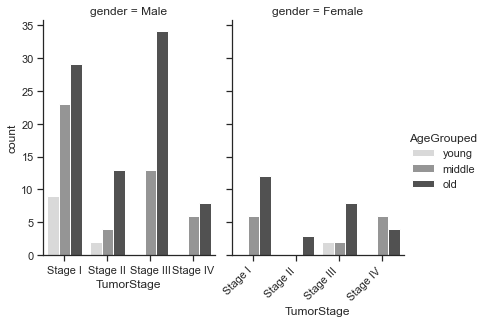

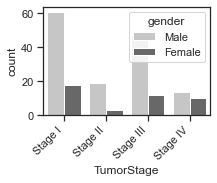

In [11]:
g = sns.catplot(x="TumorStage", hue="AgeGrouped", col="gender",
                order=['Stage I', 'Stage II', 'Stage III', 'Stage IV'],
                data=prot_sample_df, kind="count", palette='Greys', hue_order=['young', 'middle', 'old'],
                height=4, aspect=.7)
plt.xticks(rotation=45, ha='right')
if save_fig:
    plt.savefig(f'{fig_dir}patient_demographics_age.svg')

plt.show()

# Also look at the gender
g = sns.countplot(x="TumorStage", hue="gender",
                order=['Stage I', 'Stage II', 'Stage III', 'Stage IV'],
                data=prot_sample_df, palette='Greys')
plt.xticks(rotation=45, ha='right')
if save_fig:
    plt.savefig(f'{fig_dir}patient_demographics.svg')

In [12]:
rna_sample_df['AgeGrouped'].value_counts()

old       139
middle     85
young      15
Name: AgeGrouped, dtype: int64

In [13]:
rna_sample_df['TumorStage'].value_counts()

Stage I      99
Stage III    74
Stage IV     37
Stage II     29
Name: TumorStage, dtype: int64

## Code for plotting the separation of patients

In [16]:
# Have a look at clustering each of these
from sklearn.decomposition import PCA

def do_plts(df, sample_df, title, fig_dir, value="CPT"):
    cases = [c for c in df.columns if value in c]
    corr = df[cases].corr()
    row_colors_t = [[], [], [], []]
    ages = sample_df['AgeGrouped'].values
    genders = sample_df['gender'].values
    #cimps = sample_df['CIMPStatus'].values
    for i, c in enumerate(sample_df['CondId'].values):
        if c == 1:
            row_colors_t[0].append('red')
        else:
            row_colors_t[0].append('blue')
        if ages[i] == 'middle':
            row_colors_t[1].append('grey')
        elif ages[i] == 'old':
            row_colors_t[1].append('black') 
        else:
            row_colors_t[1].append('lightgrey') 
            
        if genders[i] == 'Male':
            row_colors_t[2].append('green')
        else:
            row_colors_t[2].append('yellow') 
        row_colors_t[3].append('pink')

    sns.clustermap(corr, 
                    xticklabels=sample_df['FullLabel'].values,
                    yticklabels=sample_df['FullLabel'].values, cmap='RdBu_r', row_cluster=True, 
                    col_cluster=True, row_colors=row_colors_t)
    plt.title(title)
    if save_fig:
        plt.savefig(os.path.join(fig_dir, f'Heatmap_{title}.svg'))
    plt.show()

    vals = df[cases].values.T
    pca = PCA(n_components=2)
    pca_values = pca.fit_transform(vals)
    var_ratio = pca.fit(vals).explained_variance_ratio_

    """
    ---------------------------------------------------------------
                Plot PCA
    ---------------------------------------------------------------
    """
    plt.rcParams['figure.figsize'] = [4, 4]

    plt.scatter(pca_values[:, 0], pca_values[:, 1], c=row_colors_t[0], s=400, edgecolors=row_colors_t[2], linewidths=1.5)
    plt.scatter(pca_values[:, 0], pca_values[:, 1], c=row_colors_t[3], s=100, marker="X", edgecolors=row_colors_t[1], linewidths=1.5)

    plt.title(f'{title} PCA VAR: 0: {var_ratio[0]}, 1: {var_ratio[1]}')
    if save_fig:
        plt.savefig(os.path.join(fig_dir, f'PCA_{title}.svg'))

    # Now we want to fit everything except the gene IDs 
    plt.show()

## Generate datasets

## Save all tumour vs normal

RNA 66 173 239 239


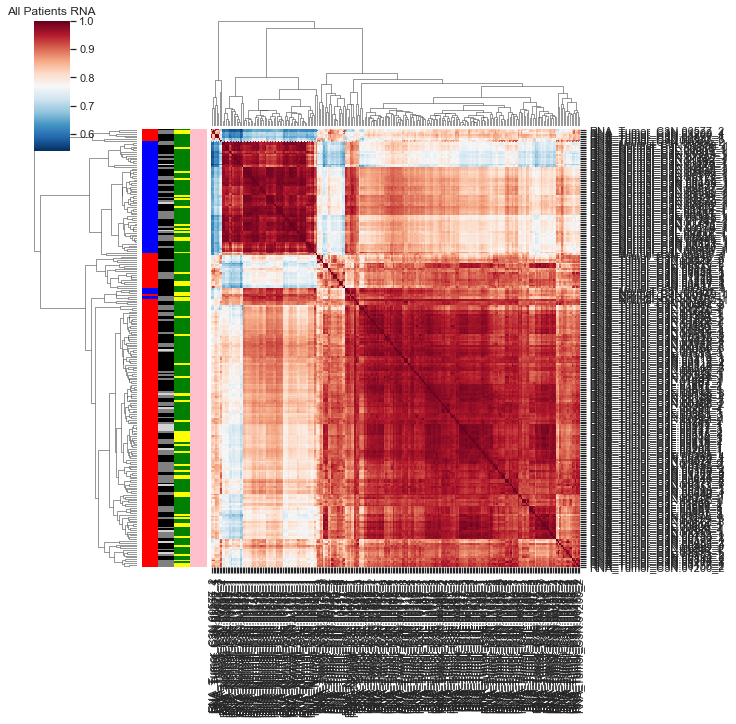

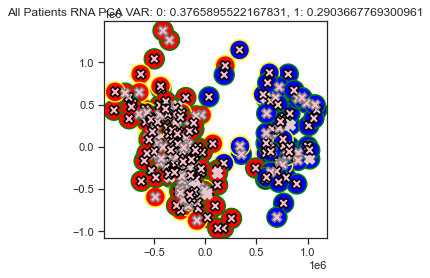

In [17]:
test_title = 'all_patients_ccRCC'

# RNA
meta_cols = [c for c in rna_df.columns if 'RNA' not in c and 'Unnamed' not in c]
normal_cases = [c.split('_')[2] for c in rna_df.columns if 'Normal' in c]
tumour_cases = [c.split('_')[2] for c in rna_df.columns if 'Tumor' in c]
cases_matched = [c for c in tumour_cases] + [c for c in normal_cases] #[c for c in tumour_cases if c in normal_cases]
case_cols = [c for c in rna_df.columns if 'RNA' in c and c.split('_')[2] in cases_matched]
print("RNA", len(normal_cases), len(tumour_cases), len(cases_matched), len(case_cols))
sub_sample_df = rna_sample_df[rna_sample_df['FullLabel'].isin(case_cols)]
data_df = rna_df[meta_cols + list(rna_sample_df['FullLabel'].values)]
sub_sample_df.to_csv(os.path.join(output_dir, f'rna_sample_data_{test_title}_sircle.csv'))
data_df.to_csv(os.path.join(output_dir, f'rna_data_{test_title}_sircle.csv'), index=False)
do_plts(data_df, sub_sample_df, 'All Patients RNA', fig_dir, value="RNA")


Protein 81 103 184 184


/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


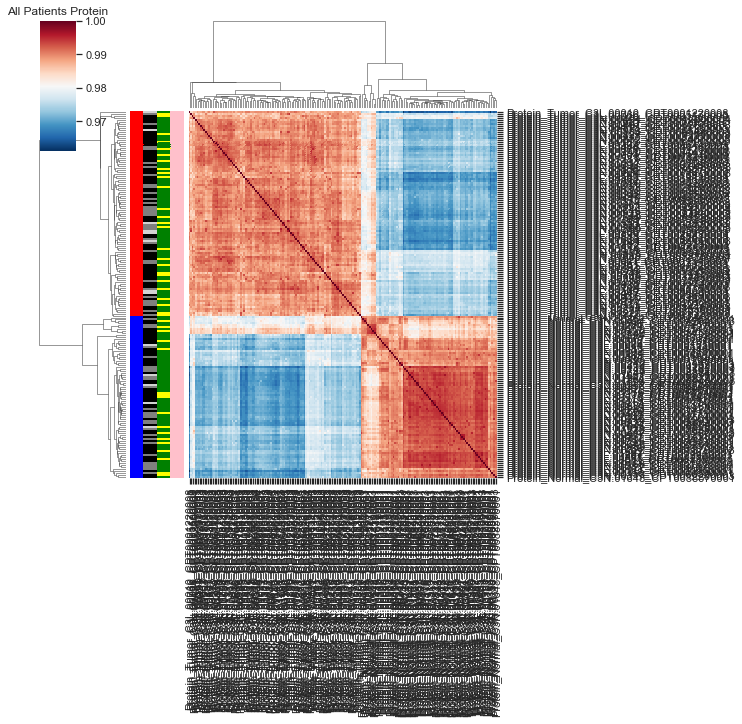

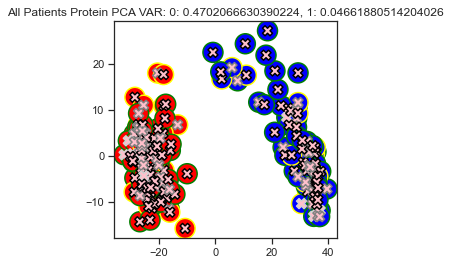

In [18]:
# Protein
meta_cols = [c for c in prot_df.columns if 'Protein' not in c]
case_cols = [c for c in prot_df.columns if 'Protein' in c]
normal_cases = [c.split('_')[2] for c in prot_df.columns if 'Normal' in c]
tumour_cases = [c.split('_')[2] for c in prot_df.columns if 'Tumor' in c]
cases_matched = [c for c in tumour_cases] + [c for c in normal_cases] #[c for c in tumour_cases if c in normal_cases]
case_cols = [c for c in prot_df.columns if 'Protein' in c and c.split('_')[2] in cases_matched]
print("Protein", len(normal_cases), len(tumour_cases), len(cases_matched), len(case_cols))
sub_sample_df = prot_sample_df[prot_sample_df['FullLabel'].isin(case_cols)]
data_df = prot_df[meta_cols + list(prot_sample_df['FullLabel'].values)]
sub_sample_df.to_csv(os.path.join(output_dir, f'prot_sample_data_{test_title}_sircle.csv'))
data_df.to_csv(os.path.join(output_dir, f'prot_data_{test_title}_sircle.csv'), index=False)
do_plts(data_df, sub_sample_df, 'All Patients Protein', fig_dir, value="Protein")


METH 151 100 251 251


/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


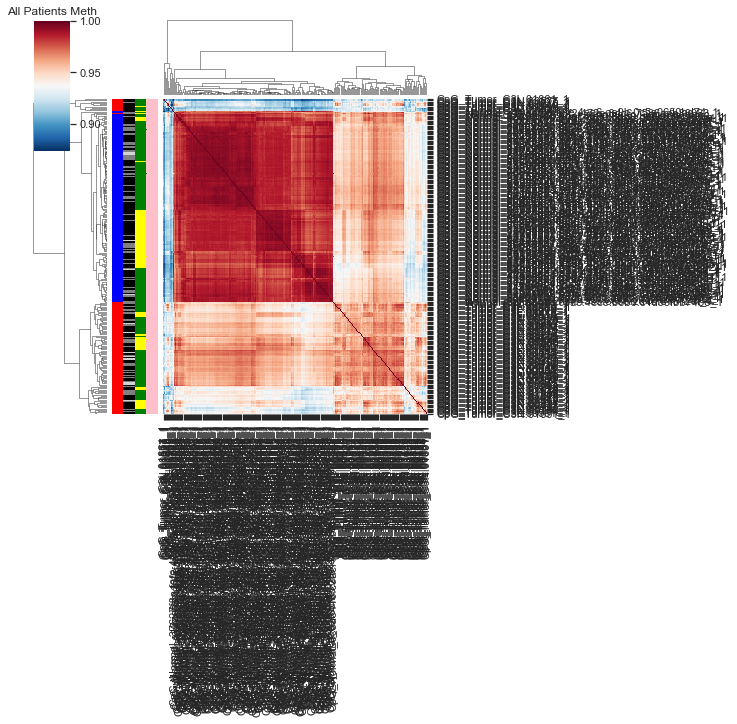

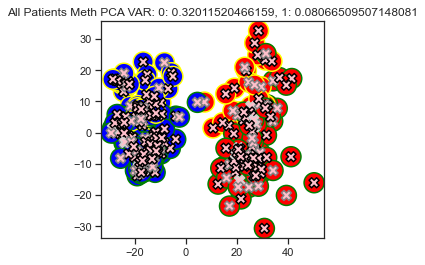

In [19]:
# Methylation
meta_cols = [c for c in meth_df.columns if 'CpG' not in c]
case_cols = [c for c in meth_df.columns if 'CpG' in c]
sub_sample_df = meth_sample_df[meth_sample_df['FullLabel'].isin(case_cols)]
data_df = meth_df[meta_cols + list(sub_sample_df['FullLabel'].values)]
normal_cases = [c.split('_')[2] for c in meth_df.columns if 'Normal' in c]
tumour_cases = [c.split('_')[2] for c in meth_df.columns if 'Tumor' in c]
cases_matched =[c for c in tumour_cases] + [c for c in normal_cases] # [c for c in tumour_cases if c in normal_cases]
print("METH", len(normal_cases), len(tumour_cases), len(cases_matched), len(case_cols))
sub_sample_df.to_csv(os.path.join(output_dir, f'cpg_sample_data_{test_title}_sircle.csv'))
data_df.to_csv(os.path.join(output_dir, f'cpg_data_{test_title}_sircle.csv'), index=False)
do_plts(data_df, sub_sample_df, 'All Patients Meth', fig_dir, value="CpG")



## Merge all clinical information for patients from TCGA and CPTAC

In [31]:
# Save to csv file
cptac_clin_df = pd.read_csv(f'{output_dir}clinical_sircle_13052022.csv')
tcga_clin_df = pd.read_csv(f'{output_dir}clinical_TCGA_13052022.csv')
tcga_cptac_clin = cptac_clin_df.append(tcga_clin_df)
stages = []
for stage in tcga_cptac_clin['TumorStage'].values:
    if stage == 'Stage I' or stage == 'Stage II':
        stages.append('Early')
    elif stage == 'Stage III' or stage == 'Stage IV':
        stages.append('Late')
    else:
        stages.append(None)
tcga_cptac_clin['Stage'] = stages
# Make a new column which is comparing BAP1 vs PBRM1 mutations
mutation_combined = []
bap1 = tcga_cptac_clin['BAP1_mutation'].values
for i, pbrm1 in enumerate(tcga_cptac_clin['PBRM1_mutation'].values):
    if bap1[i] == 1 and pbrm1 == 0:
        mutation_combined.append('BAP1')
    elif  bap1[i] == 0 and pbrm1 == 1:
        mutation_combined.append('PBRM1')
    else:
        mutation_combined.append(None)
        
tcga_cptac_clin['BAP1&PBRM1'] = mutation_combined
print(len(tcga_cptac_clin[tcga_cptac_clin['BAP1&PBRM1'] == 'PBRM1']), len(tcga_cptac_clin[tcga_cptac_clin['BAP1&PBRM1'] == 'BAP1']))
tcga_cptac_clin.to_csv(f'{output_dir}clinical_CPTAC_TCGA.csv', index=False)
clin_df = tcga_cptac_clin

88 23


## Do PCA plots

In [32]:
case_to_stage = dict(zip(clin_df.SafeCases, clin_df.TumorStage))
case_to_age = dict(zip(clin_df.SafeCases, clin_df.AgeGrouped))
case_to_mutation = dict(zip(clin_df.SafeCases, clin_df['BAP1&PBRM1'].values))
opts = {'title_font_weight': 'bold', "title_font_size":9, "label_font_size":7, "figsize": (1.5, 1.5),
        "s": 50, 'opacity': 0.5}

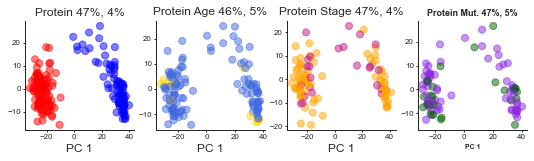

In [33]:
#Protein 
## Do some PCA plots just for QC
from sklearn.decomposition import PCA
from sciviso import Scatterplot

title = 'Protein'
df = prot_df
cols = [c for c in df.columns if title in c]
plt.rcParams["figure.figsize"] = (9, 2)

fig_size = (2, 2)
vis_opts = {"figsize": fig_size, "title_font_size": 12, "axis_font_size": 10, 
           'palette': ['lightgrey', 'dimgrey']}

age_colours = {'young': 'gold', 'old': 'royalblue'}
mut_colours = {'BAP1': 'darkgreen', 'PBRM1': 'blueviolet'}
stage_colours = {'Stage I': 'orange', 'Stage IV': 'mediumvioletred'}
tvn_colours = {'Tumor': 'red', 'Normal': 'blue'}


age_colours = [age_colours.get(case_to_age[c.split('_')[2]]) for c in cols]
stage_colours = [stage_colours.get(case_to_stage[c.split('_')[2]]) for c in cols]
mut_colours = [mut_colours.get(case_to_mutation[c.split('_')[2]]) for c in cols]
tvn_colours = [tvn_colours.get(c.split('_')[1]) for c in cols]

colours = [tvn_colours, age_colours, stage_colours, mut_colours]
fig, ax = plt.subplots(nrows=1, ncols=4)
for i, title in enumerate([f'{title}', f'{title} Age', f'{title} Stage', f'{title} Mut.']):
    colour = colours[i]
    vals = df[[cols[j] for j, c in enumerate(colour) if c is not None]].values.T
    colour = [colour[j] for j, c in enumerate(colour) if c is not None]
    pca = PCA(n_components=2)
    pca_values = pca.fit_transform(vals)
    var_ratio = pca.fit(vals).explained_variance_ratio_
    vis_df = pd.DataFrame()
    vis_df['PC 1'] = pca_values[:, 0]
    vis_df['PC 2'] = pca_values[:, 1]
    sc = Scatterplot(vis_df, x = 'PC 1', y = 'PC 2',
                     colour = colour,
                     s=50, config=opts)

    sc.axis_line_width = 1.0
    sc.plot(ax=ax[i])
    # Select some colours 
    ax[i].title.set_text(f'{title} {int(100 * var_ratio[0])}%, {int(100 * var_ratio[1])}%')
    ax[i].set(xlabel='PC 1')
    #ax[i].set(ylabel='PC 2')
    
if save_fig:
    plt.savefig(os.path.join(fig_dir, f'PCA_{title}.svg'))
plt.show()

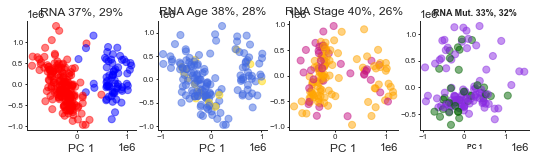

In [34]:
title = 'RNA'
df = rna_df
cols = [c for c in df.columns if title in c]
plt.rcParams["figure.figsize"] = (9, 2)

fig_size = (2, 2)
vis_opts = {"figsize": fig_size, "title_font_size": 12, "axis_font_size": 10, 
           'palette': ['lightgrey', 'dimgrey']}

age_colours = {'young': 'gold', 'old': 'royalblue'}
mut_colours = {'BAP1': 'darkgreen', 'PBRM1': 'blueviolet'}
stage_colours = {'Stage I': 'orange', 'Stage IV': 'mediumvioletred'}
tvn_colours = {'Tumor': 'red', 'Normal': 'blue'}


age_colours = [age_colours.get(case_to_age[c.split('_')[2]]) for c in cols]
stage_colours = [stage_colours.get(case_to_stage[c.split('_')[2]]) for c in cols]
mut_colours = [mut_colours.get(case_to_mutation[c.split('_')[2]]) for c in cols]
tvn_colours = [tvn_colours.get(c.split('_')[1]) for c in cols]

colours = [tvn_colours, age_colours, stage_colours, mut_colours]
fig, ax = plt.subplots(nrows=1, ncols=4)
for i, title in enumerate([f'{title}', f'{title} Age', f'{title} Stage', f'{title} Mut.']):
    colour = colours[i]
    vals = df[[cols[j] for j, c in enumerate(colour) if c is not None]].values.T
    colour = [colour[j] for j, c in enumerate(colour) if c is not None]
    pca = PCA(n_components=2)
    pca_values = pca.fit_transform(vals)
    var_ratio = pca.fit(vals).explained_variance_ratio_
    vis_df = pd.DataFrame()
    vis_df['PC 1'] = pca_values[:, 0]
    vis_df['PC 2'] = pca_values[:, 1]
    sc = Scatterplot(vis_df, x = 'PC 1', y = 'PC 2',
                     colour = colour,
                     s=50, config=opts)

    sc.axis_line_width = 1.0
    sc.plot(ax=ax[i])
    # Select some colours 
    ax[i].title.set_text(f'{title} {int(100 * var_ratio[0])}%, {int(100 * var_ratio[1])}%')
    ax[i].set(xlabel='PC 1')
    #ax[i].set(ylabel='PC 2')
plt.savefig(os.path.join(fig_dir, f'PCA_{title}.svg'))
plt.show()

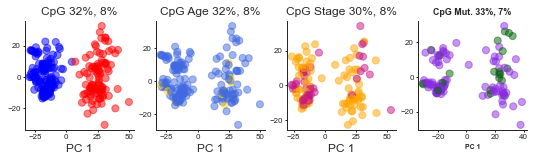

In [36]:
title = 'CpG'
df = meth_df
cols = [c for c in df.columns if title in c and 'diff' not in c]
plt.rcParams["figure.figsize"] = (9, 2)

fig_size = (2, 2)
vis_opts = {"figsize": fig_size, "title_font_size": 12, "axis_font_size": 10, 
           'palette': ['lightgrey', 'dimgrey']}

age_colours = {'young': 'gold', 'old': 'royalblue'}
mut_colours = {'BAP1': 'darkgreen', 'PBRM1': 'blueviolet'}
stage_colours = {'Stage I': 'orange', 'Stage IV': 'mediumvioletred'}
tvn_colours = {'Tumor': 'red', 'Normal': 'blue'}


age_colours = [age_colours.get(case_to_age[c.split('_')[2]]) for c in cols]
stage_colours = [stage_colours.get(case_to_stage[c.split('_')[2]]) for c in cols]
mut_colours = [mut_colours.get(case_to_mutation[c.split('_')[2]]) for c in cols]
tvn_colours = [tvn_colours.get(c.split('_')[1]) for c in cols]

colours = [tvn_colours, age_colours, stage_colours, mut_colours]
fig, ax = plt.subplots(nrows=1, ncols=4)
for i, title in enumerate([f'{title}', f'{title} Age', f'{title} Stage', f'{title} Mut.']):
    colour = colours[i]
    vals = df[[cols[j] for j, c in enumerate(colour) if c is not None]].values.T
    colour = [colour[j] for j, c in enumerate(colour) if c is not None]
    pca = PCA(n_components=2)
    pca_values = pca.fit_transform(vals)
    var_ratio = pca.fit(vals).explained_variance_ratio_
    vis_df = pd.DataFrame()
    vis_df['PC 1'] = pca_values[:, 0]
    vis_df['PC 2'] = pca_values[:, 1]
    sc = Scatterplot(vis_df, x = 'PC 1', y = 'PC 2',
                     colour = colour,
                     s=50, config=opts)

    sc.axis_line_width = 1.0
    sc.plot(ax=ax[i])
    # Select some colours 
    ax[i].title.set_text(f'{title} {int(100 * var_ratio[0])}%, {int(100 * var_ratio[1])}%')
    ax[i].set(xlabel='PC 1')
    #ax[i].set(ylabel='PC 2')
plt.savefig(os.path.join(fig_dir, f'PCA_{title}.svg'))
plt.show()